# Attack on Diva using a Decision Tree

In this notebook I use the same dataset of the decision trees to build the shadow models and I keep all the elements generated by LIME, without filtering using the mean + std

In [1]:
from pathlib import Path
import sys
from numba import njit

UTILS_RELATIVE_PATH = "../../../../"
sys.path.append(UTILS_RELATIVE_PATH)

MLEM_RELATIVE_PATH = "../../../../.."
sys.path.append(MLEM_RELATIVE_PATH)

LIME_RELATIVE_PATH = "../../../../../lime/"
sys.path.append(LIME_RELATIVE_PATH)

OUTPUT_FOLDER = Path("experiment_output")
OUTPUT_FOLDER.mkdir(exist_ok=True)

import logging
logging.disable('DEBUG')


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
import numpy as np
import scipy.spatial.distance as distance
import multiprocessing

np.random.seed(4321)
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer # type: ignore
from mlem.utilities import generate_balanced_dataset, save_pickle_bz2, load_pickle_bz2, save_txt

importing the experiment utilities and the mlem module

# Loading the Diva data

loading the Diva RandomForest and the dictionary with all the useful data

In [3]:
from utils.dataloading.diva import load_diva_data, load_diva_randomforest # type: ignore

BB = load_diva_randomforest()
BB_DATA = load_diva_data()

print(classification_report(BB_DATA['y_test'], BB.predict(BB_DATA['X_test'])))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2094
           1       0.85      0.77      0.81       745

    accuracy                           0.90      2839
   macro avg       0.89      0.86      0.87      2839
weighted avg       0.90      0.90      0.90      2839



# Creating the explainer

In [4]:
explainer_training_data = BB_DATA['X_train']
explainer = LimeTabularExplainer(training_data=explainer_training_data, categorical_features=[i for (i, el) in enumerate(BB_DATA['categorical_features_mask']) if el], random_state=123)

def generate_data_lime(x, num_samples):
    return explainer.data_inverse(x, num_samples+1, 'gaussian')[1][1:]

# Generating the lime datasets

In [5]:
test_representatives_x = BB_DATA['X_attack_5_per_quantile']
test_representatives_y = BB_DATA['y_attack_5_per_quantile']
n_datasets = len(test_representatives_x)
print(n_datasets)

40


In [6]:
def generate_and_save(index, instance):
    # wrapper of the above functions to be able to generate the datasets in parallel
    output_path = OUTPUT_FOLDER / f"{index}"
    output_path.mkdir(exist_ok=True)
    balanced_dataset = generate_balanced_dataset(instance, 5000, BB, generate_data_lime)
    balanced_dataset.to_csv(output_path / "lime_generated.csv", index=False)
    with open(output_path / "instance.npy", "wb") as f:
        np.save(f, instance)


if not any([Path(OUTPUT_FOLDER / f"{j}" / "lime_generated.csv").exists() for j in range(len(test_representatives_x))]):
    with multiprocessing.Pool(processes=8) as pool:
        pool.starmap(generate_and_save, [*enumerate(test_representatives_x)])
else:
    print("The lime generated datasets already exist")

The lime generated datasets already exist


# Creating the Decision Trees

Creating the decision trees <span style="color:red"> if they don't already exist </span>.

In [7]:
from mlem.utilities import create_decision_tree

def train_decision_tree(datapath, model_name):
    lime_dataset = pd.read_csv(datapath / "lime_generated.csv")
    X_train, X_test, y_train, y_test = train_test_split(lime_dataset.drop('Target', axis=1).to_numpy(), lime_dataset.Target.to_numpy(), test_size=0.33, random_state=42)
    model_path = datapath / model_name
    if not model_path.exists():
        dt = create_decision_tree(X_train, y_train, use_halving=True) 
        save_pickle_bz2(model_path, dt)
        save_txt(datapath / "dt_classification_report.txt", classification_report(y_test, dt.predict(X_test)))

In [8]:
models_name = "dt.bz2"
if not any([Path(OUTPUT_FOLDER / f"{j}" / "dt.bz2").exists() for j in range(len(test_representatives_x))]):
    with multiprocessing.Pool(8) as pool:
        pool.starmap(train_decision_tree, [(Path(OUTPUT_FOLDER / f"{i}"), models_name) for i in range(len(test_representatives_x))])
else:
    print("The DecisionTrees already exist")

The DecisionTrees already exist


# Attack on the Decision Trees to create the attack models

Attack on the decision trees using the <span style="background: green">lime-generated dataset</span> labeled by the decision trees to create the shadow models.

In [9]:
categorical_features_mask = BB_DATA['categorical_features_mask']

Creating the shadow models and the attack models.

In [10]:
from mlem.shadow_models import ShadowModelsManager
from mlem.utilities import create_adaboost
from mlem.attack_models import AttackModelsManager, AttackStrategy

In [11]:
def compute_statistics_local_model(dataset, true_y, local_model, black_box, output_folder, filename):
    local_y = local_model.predict(dataset.to_numpy())
    local_bb = black_box.predict(dataset.to_numpy())

    report_local = classification_report(true_y.to_numpy(), local_y)
    report_bb    = classification_report(true_y.to_numpy(), local_bb)

    fidelity = str(pd.DataFrame(local_y == local_bb).value_counts(normalize=True))

    with open(output_folder / filename, "w") as f:
        f.write("Statistics on the lime generated dataset\n")
        
        f.write("local model\n")
        f.write(report_local)

        f.write("\nblack box\n")
        f.write(report_bb)

        f.write("\nFidelity between the local model and the black box\n")
        f.write(fidelity)

Run the attack only if it hasn't already been run

In [12]:
if not any([(OUTPUT_FOLDER / f"{i}" / "attack").exists() for i in range(len(test_representatives_x))]):
    
    for path in [OUTPUT_FOLDER / f"{i}" for i in range(len(test_representatives_x))]:
        # load the local tree and label the noisy dataset
        local_tree = load_pickle_bz2(path / "dt.bz2")

        lime_dataset = pd.read_csv(path / "lime_generated.csv")
        lime_dataset_x = lime_dataset.drop('Target', axis=1)
        lime_dataset_y = lime_dataset.Target

        # compute fidelity and performances on the noisy dataset.
        compute_statistics_local_model(lime_dataset_x, lime_dataset_y, local_tree, BB, path, "statistics_limegenerated.txt")

        x_attack = lime_dataset_x.to_numpy()    
        y_attack = local_tree.predict(x_attack)

        path_shadow = str(path / "shadow")

        shadow_models = ShadowModelsManager(
            n_models=4,
            results_path=path_shadow,
            test_size=0.5,
            random_state=123,
            model_creator_fn=create_adaboost,
            categorical_mask=categorical_features_mask
        )
        # x_attack is the noisy dataset
        shadow_models.fit(x_attack, y_attack)

        # extracting the dataset for the attack models
        attack_models_dataset = shadow_models.get_attack_dataset()

        # saving the attack dataset
        attack_models_dataset.to_csv(path / "attack_models_train_dataset.csv", index=False)

        # Creating the attack model for each label using Adaboost
        path_attack = str(path / "attack")
        attack_models = AttackModelsManager(
                results_path=path_attack, model_creator_fn=create_adaboost, attack_strategy=AttackStrategy.ONE_PER_LABEL
        )
        
        attack_models.fit(attack_models_dataset)
else:
    print("The attack models already exist")

The attack models already exist


By looking at the test reports of the attack models, it seems that they <span style="background: red">perform bad on both classes</span> with an accuracy of $\simeq .53$

# Creating the ensembles

In [13]:
from mlem.ensemble import HardVotingClassifier, SoftVotingClassifier, KMostSureVotingClassifier
from utils.attack_evaluation import evaluate_attack

In [14]:
attack_models_0 = [load_pickle_bz2(OUTPUT_FOLDER / f"{i}" / "attack" / "0" / "model.pkl.bz2") for i in range(len(test_representatives_x))]
attack_models_1 = [load_pickle_bz2(OUTPUT_FOLDER / f"{i}" / "attack" / "1" / "model.pkl.bz2") for i in range(len(test_representatives_x))]

## Hard Voting

In [15]:
hv0 = HardVotingClassifier(classifiers=attack_models_0)
hv1 = HardVotingClassifier(classifiers=attack_models_1)

report full
              precision    recall  f1-score   support

          in       0.71      0.27      0.39      6539
         out       0.30      0.74      0.43      2801

    accuracy                           0.41      9340
   macro avg       0.50      0.50      0.41      9340
weighted avg       0.59      0.41      0.40      9340


Class 0
              precision    recall  f1-score   support

          in       0.68      0.03      0.06      4908
         out       0.30      0.97      0.46      2135

    accuracy                           0.31      7043
   macro avg       0.49      0.50      0.26      7043
weighted avg       0.56      0.31      0.18      7043


Class 1
              precision    recall  f1-score   support

          in       0.71      0.97      0.82      1631
         out       0.27      0.02      0.04       666

    accuracy                           0.70      2297
   macro avg       0.49      0.50      0.43      2297
weighted avg       0.58      0.70      0.60 

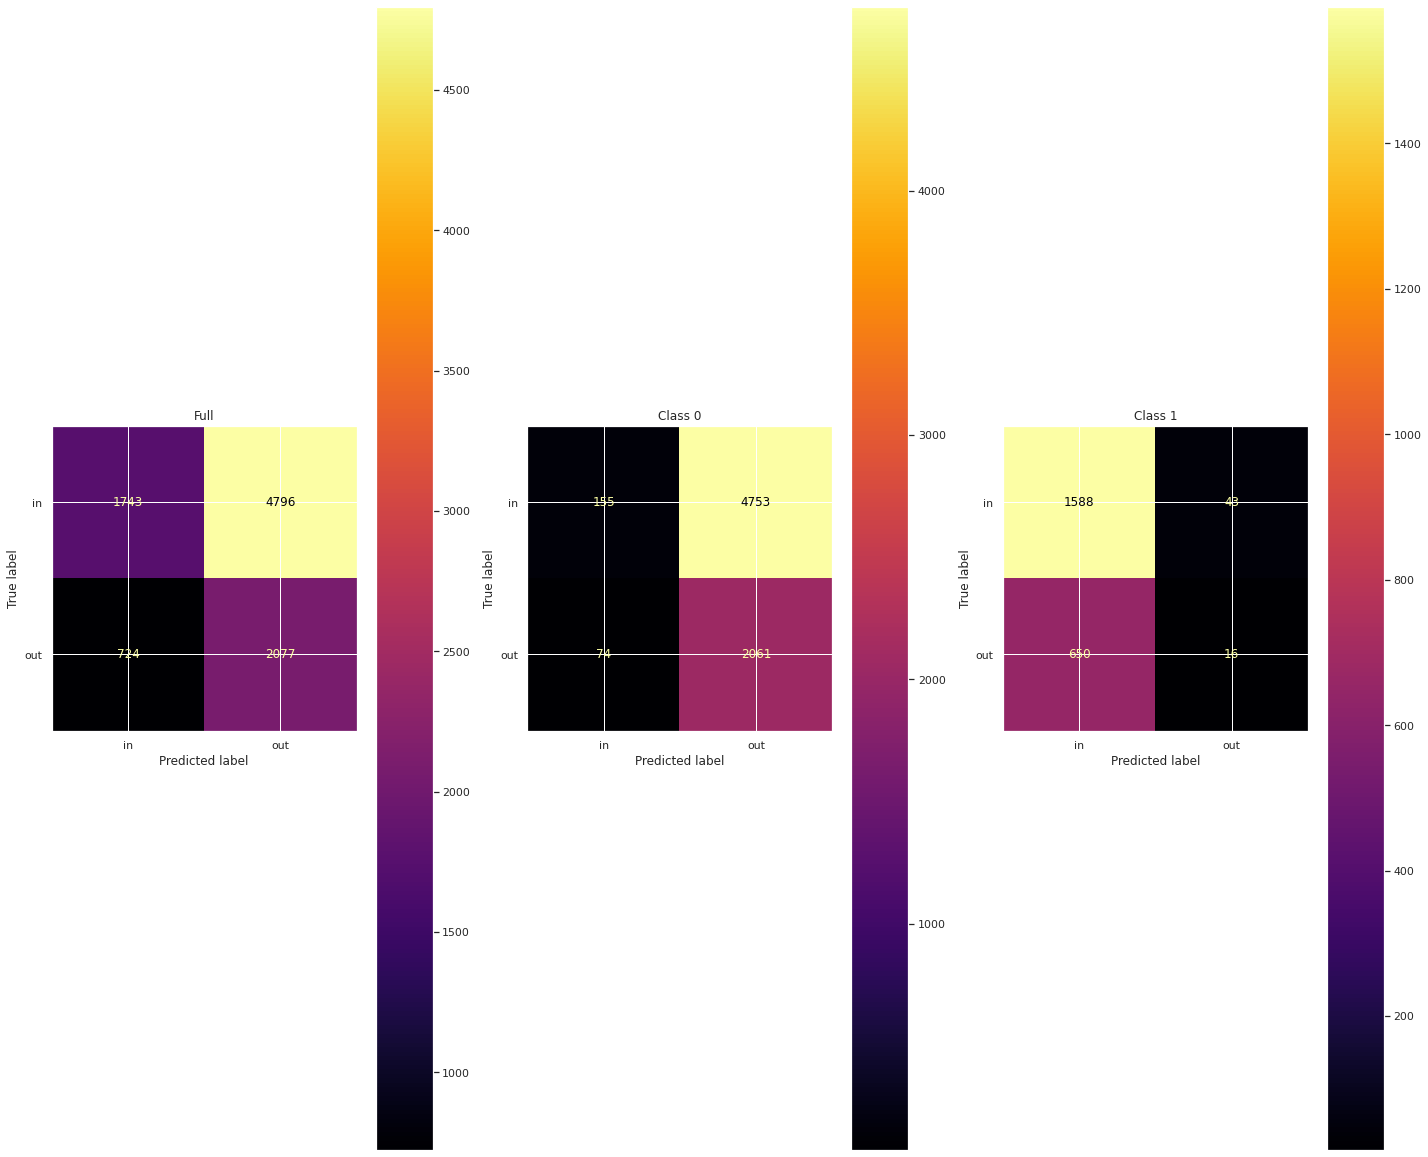

In [16]:
evaluate_attack(hv0, hv1, BB, BB_DATA)

report full
              precision    recall  f1-score   support

          in       0.73      0.24      0.36      6551
         out       0.31      0.79      0.44      2812

    accuracy                           0.40      9363
   macro avg       0.52      0.51      0.40      9363
weighted avg       0.60      0.40      0.39      9363


Class 0
              precision    recall  f1-score   support

          in       0.66      0.01      0.03      4917
         out       0.30      0.98      0.46      2145

    accuracy                           0.31      7062
   macro avg       0.48      0.50      0.25      7062
weighted avg       0.55      0.31      0.16      7062


Class 1
              precision    recall  f1-score   support

          in       0.73      0.92      0.81      1634
         out       0.45      0.16      0.24       667

    accuracy                           0.70      2301
   macro avg       0.59      0.54      0.53      2301
weighted avg       0.65      0.70      0.65 

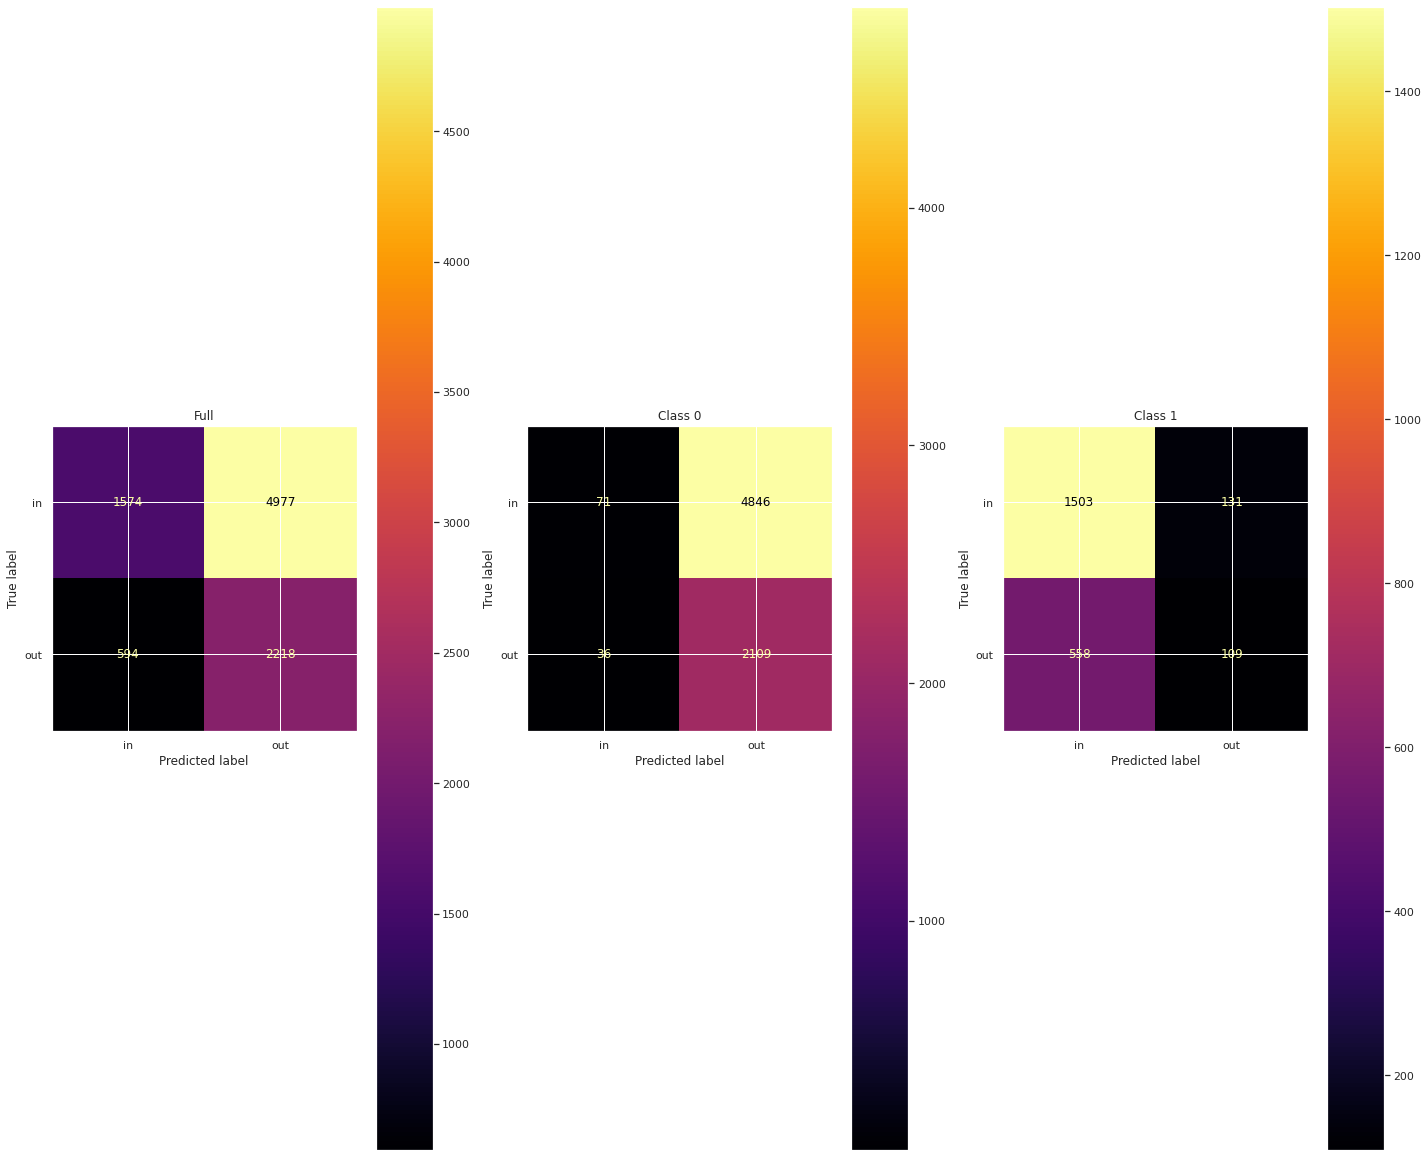

In [17]:
evaluate_attack(hv0, hv1, BB, BB_DATA, split_true_label=True)

## Soft Voting

In [18]:
sv0 = SoftVotingClassifier(classifiers=attack_models_0)
sv1 = SoftVotingClassifier(classifiers=attack_models_1)

report full
              precision    recall  f1-score   support

          in       0.70      0.27      0.39      6624
         out       0.30      0.74      0.43      2839

    accuracy                           0.41      9463
   macro avg       0.50      0.50      0.41      9463
weighted avg       0.58      0.41      0.40      9463


Class 0
              precision    recall  f1-score   support

          in       0.64      0.03      0.06      4965
         out       0.30      0.96      0.46      2165

    accuracy                           0.31      7130
   macro avg       0.47      0.49      0.26      7130
weighted avg       0.53      0.31      0.18      7130


Class 1
              precision    recall  f1-score   support

          in       0.71      0.98      0.82      1659
         out       0.28      0.02      0.04       674

    accuracy                           0.70      2333
   macro avg       0.50      0.50      0.43      2333
weighted avg       0.59      0.70      0.60 

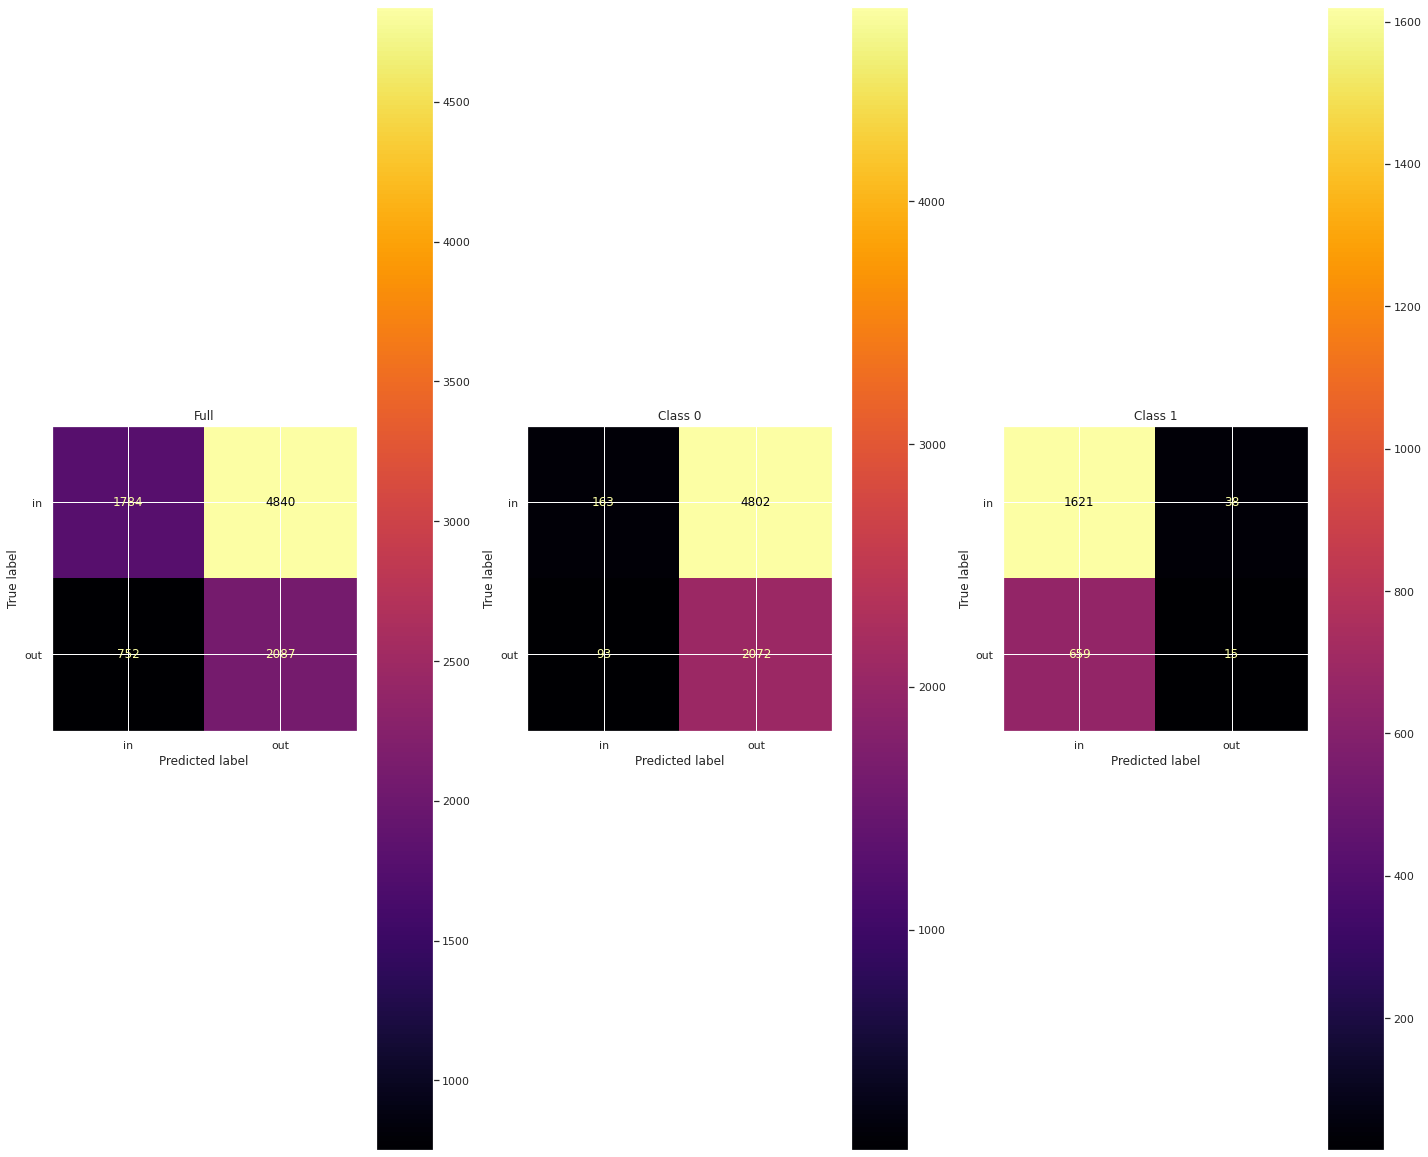

In [19]:
evaluate_attack(sv0, sv1, BB, BB_DATA)

Use the true label of the data instead of the one assigned by the black box in order to split the data before using the right ensemble

report full
              precision    recall  f1-score   support

          in       0.72      0.24      0.36      6624
         out       0.31      0.78      0.44      2839

    accuracy                           0.40      9463
   macro avg       0.52      0.51      0.40      9463
weighted avg       0.60      0.40      0.39      9463


Class 0
              precision    recall  f1-score   support

          in       0.60      0.01      0.03      4965
         out       0.30      0.98      0.46      2165

    accuracy                           0.31      7130
   macro avg       0.45      0.50      0.25      7130
weighted avg       0.51      0.31      0.16      7130


Class 1
              precision    recall  f1-score   support

          in       0.73      0.92      0.82      1659
         out       0.46      0.16      0.24       674

    accuracy                           0.70      2333
   macro avg       0.59      0.54      0.53      2333
weighted avg       0.65      0.70      0.65 

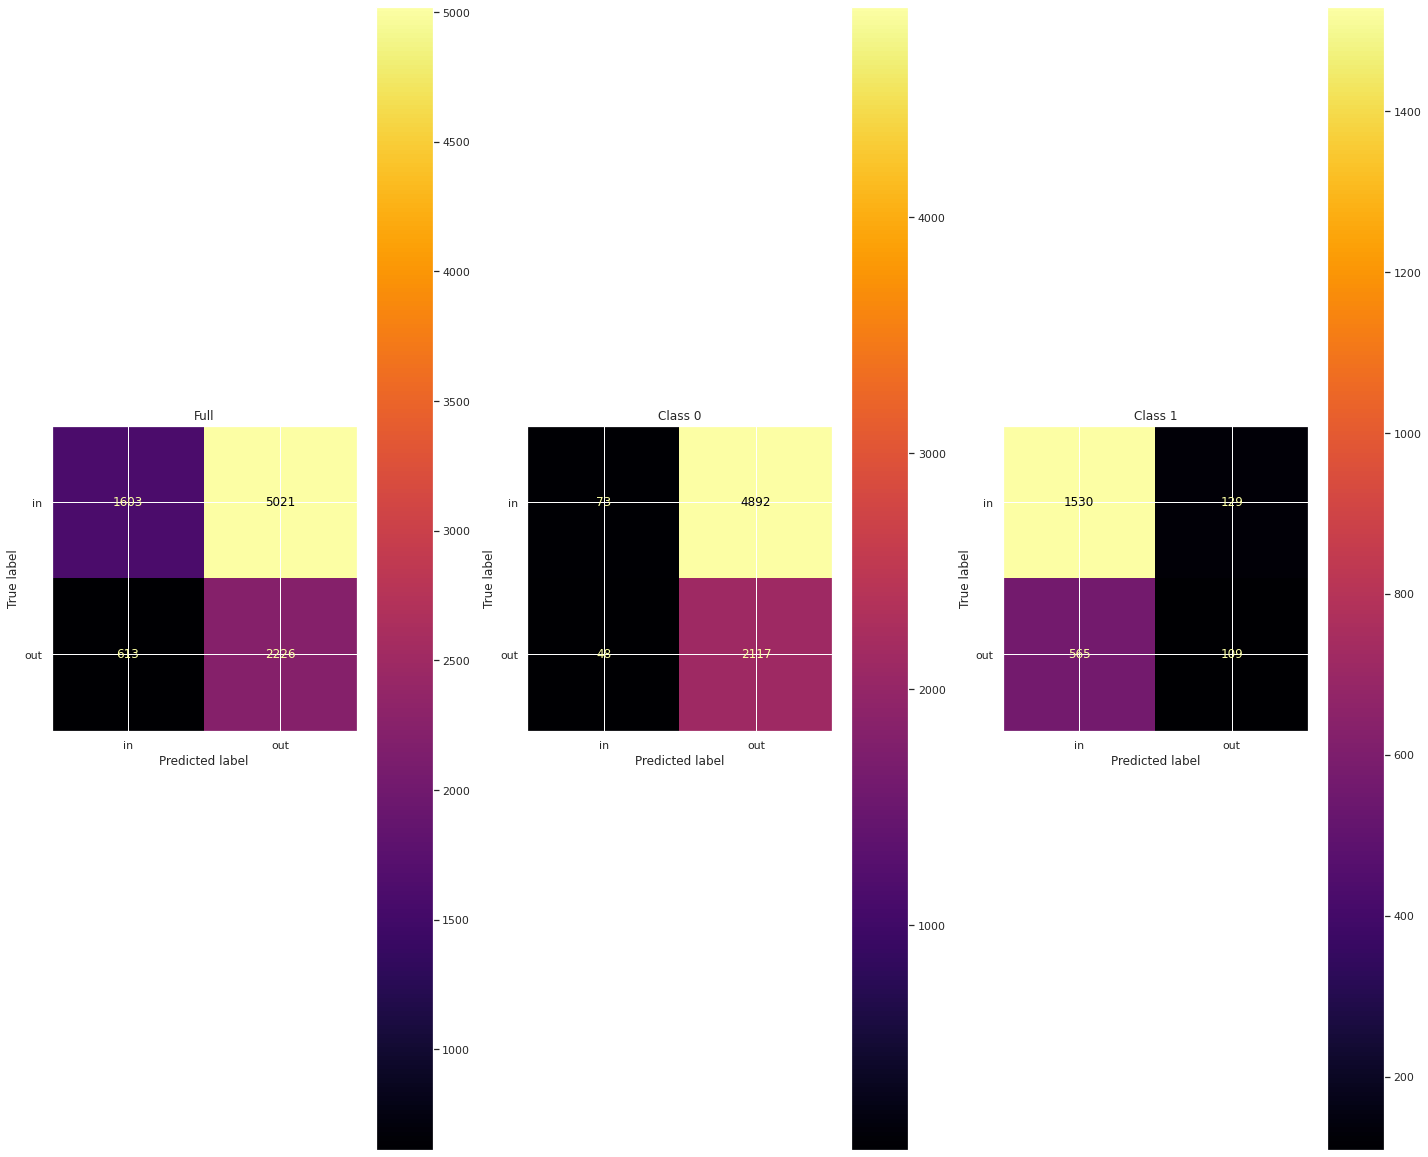

In [20]:
evaluate_attack(sv0, sv1, BB, BB_DATA, split_true_label=True)

## 5 Most sure

In [21]:
ms5_0 = KMostSureVotingClassifier(classifiers=attack_models_0)
ms5_1 = KMostSureVotingClassifier(classifiers=attack_models_1)

report full
              precision    recall  f1-score   support

          in       0.70      0.27      0.39      6624
         out       0.30      0.73      0.43      2839

    accuracy                           0.41      9463
   macro avg       0.50      0.50      0.41      9463
weighted avg       0.58      0.41      0.40      9463


Class 0
              precision    recall  f1-score   support

          in       0.63      0.03      0.06      4965
         out       0.30      0.96      0.46      2165

    accuracy                           0.31      7130
   macro avg       0.47      0.49      0.26      7130
weighted avg       0.53      0.31      0.18      7130


Class 1
              precision    recall  f1-score   support

          in       0.71      0.98      0.83      1659
         out       0.29      0.02      0.03       674

    accuracy                           0.70      2333
   macro avg       0.50      0.50      0.43      2333
weighted avg       0.59      0.70      0.60 

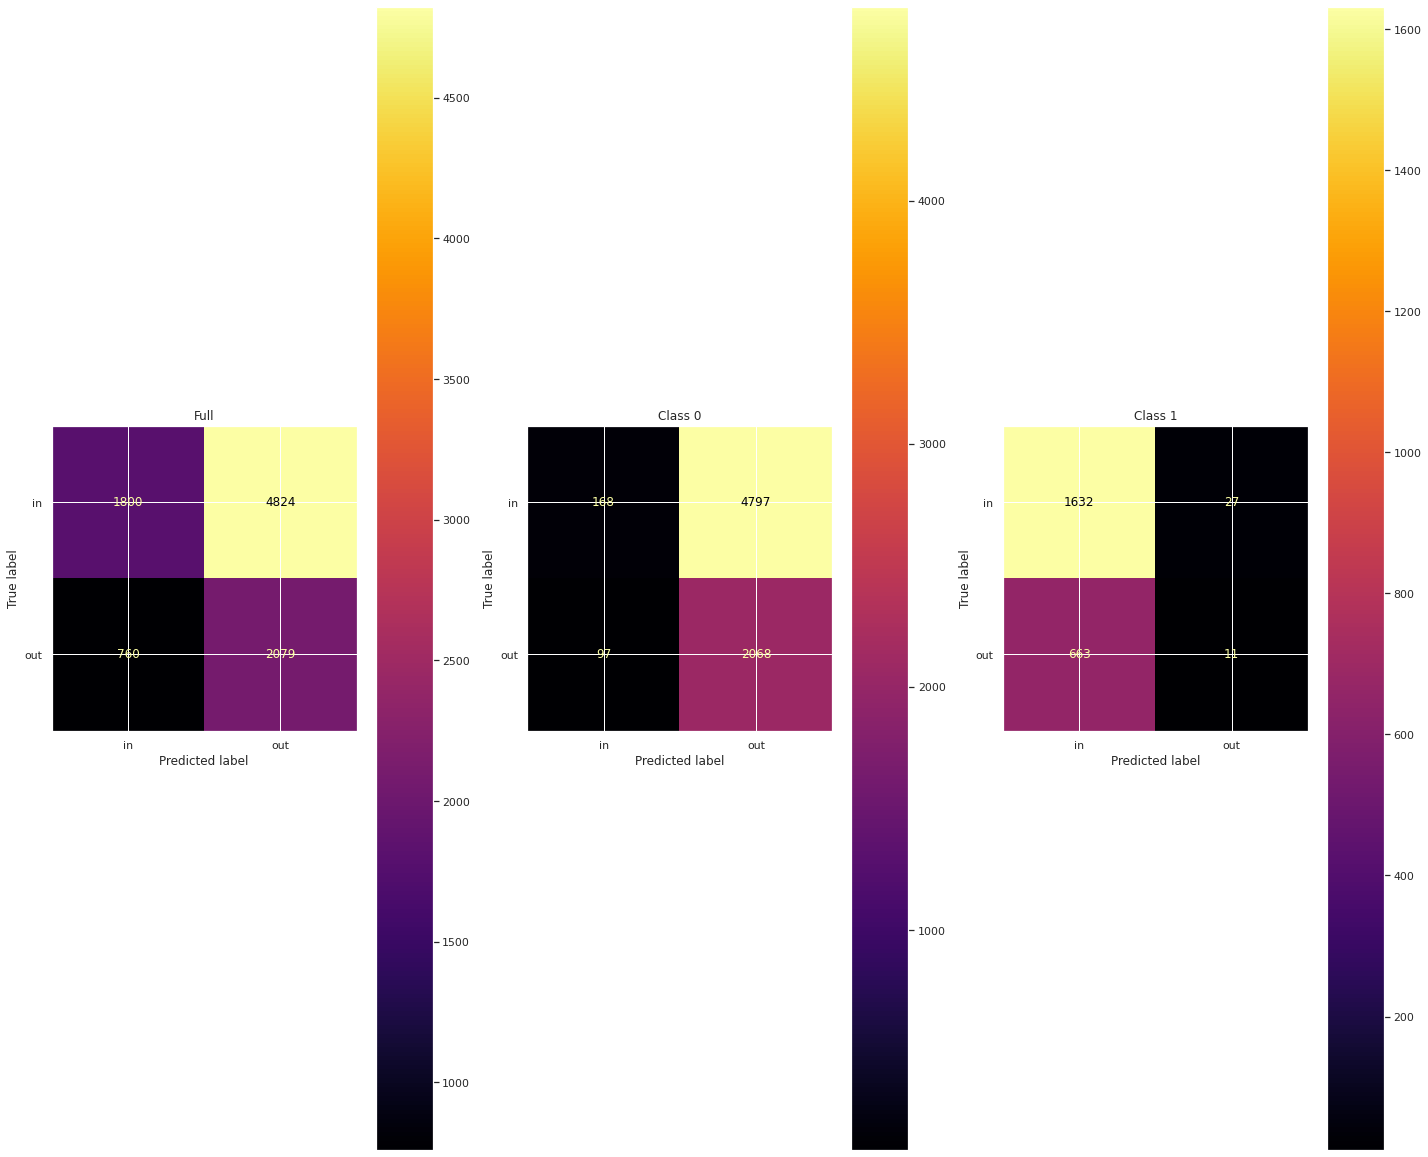

In [22]:
evaluate_attack(ms5_0, ms5_1, BB, BB_DATA)

Use the true label of the data instead of the one assigned by the black box in order to split the data before using the right ensemble

report full
              precision    recall  f1-score   support

          in       0.72      0.24      0.36      6624
         out       0.31      0.78      0.44      2839

    accuracy                           0.41      9463
   macro avg       0.52      0.51      0.40      9463
weighted avg       0.60      0.41      0.39      9463


Class 0
              precision    recall  f1-score   support

          in       0.61      0.02      0.03      4965
         out       0.30      0.98      0.46      2165

    accuracy                           0.31      7130
   macro avg       0.46      0.50      0.25      7130
weighted avg       0.52      0.31      0.16      7130


Class 1
              precision    recall  f1-score   support

          in       0.73      0.93      0.82      1659
         out       0.47      0.16      0.23       674

    accuracy                           0.70      2333
   macro avg       0.60      0.54      0.53      2333
weighted avg       0.65      0.70      0.65 

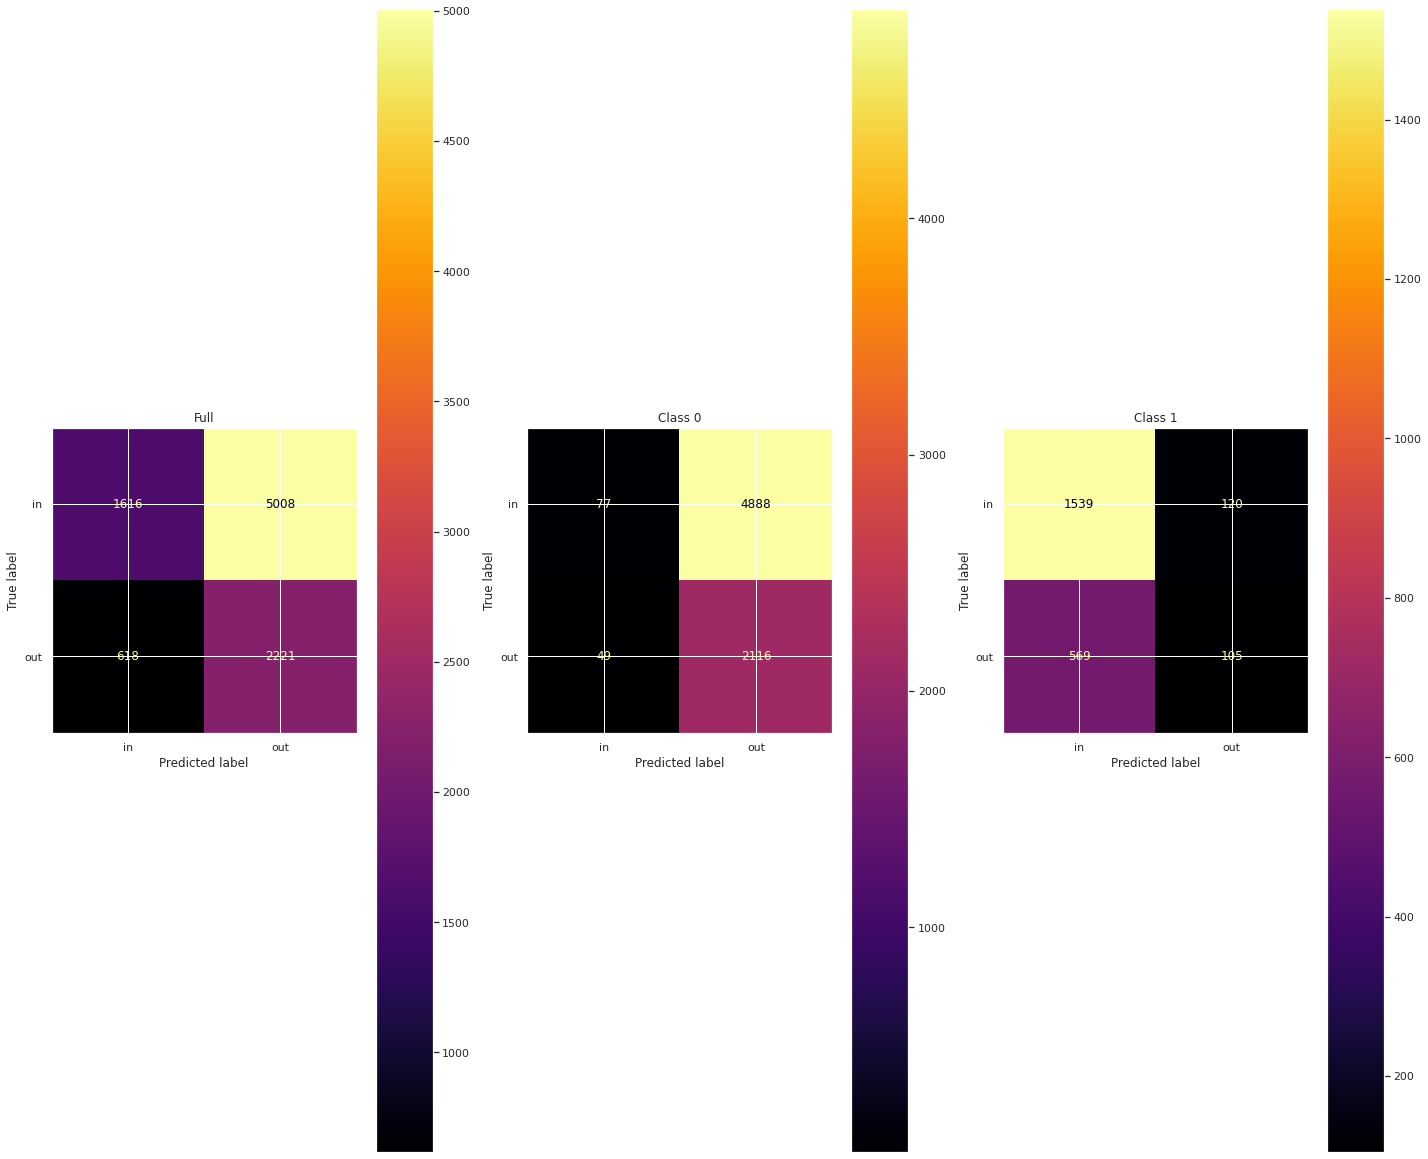

In [23]:
evaluate_attack(ms5_0, ms5_1, BB, BB_DATA, split_true_label=True)